In [36]:
from probe_attribution import get_direction, parse_cot_entry, convert_prompt_to_format, monitor_on_sequence, monitor_multiple_on_sequence, monitor_multiple_layers_on_sequence
from transformers import AutoTokenizer
import torch
from nnsight import LanguageModel
from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import numpy as np

In [3]:
model = LanguageModel(
    "openai/gpt-oss-20b",
    dtype=torch.bfloat16,
    device_map="auto"
)
tokenizer = model.tokenizer

In [4]:
all_cots = json.load(open("all_complete_cots.json"))
prompts = json.load(open("reward_hacking_prompts.json"))

In [152]:
samples = [parse_cot_entry(cot, prompts) for cot in all_cots[:2000]]
formatted_prompts = [convert_prompt_to_format(tokenizer, sample) for sample in samples]

In [153]:
def ema(seq, alpha):
    """
    Computes the exponential moving average (EMA) of a numpy array.
    
    Parameters:
        seq (np.ndarray): Input array of values.
        alpha (float): Smoothing factor between 0 and 1.
    
    Returns:
        np.ndarray: The EMA of the input array.
    """
    seq = np.asarray(seq, dtype=np.float32)
    ema_seq = np.zeros_like(seq)
    ema_seq[0] = seq[0]
    for i in range(1, len(seq)):
        ema_seq[i] = alpha * seq[i] + (1 - alpha) * ema_seq[i - 1]
    return ema_seq


In [7]:
def get_token_start_idx(prompt, search_tok="<|end|><|start|>assistant<|channel|>analysis<|message|>"):
    """
    Finds the start index in the tokens corresponding to the first occurrence of a consecutive
    sequence matching the tokenized form of `search_tok` in the tokenized `prompt`.

    Returns:
        int: Index of the first token where the search_tok sequence starts, or -1 if not found.
    """
    prompt_tokens = tokenizer.tokenize(prompt)
    search_tokens = tokenizer.tokenize(search_tok)
    n = len(search_tokens)
    for i in range(len(prompt_tokens) - n + 1):
        if prompt_tokens[i:i + n] == search_tokens:
            return i + len(search_tokens)
    return -1

In [62]:
direction = torch.load("steering_vectors.pt").to(torch.bfloat16).to("cuda:0")

In [ ]:
direction

In [77]:
test_results = []

for formatted_prompt in tqdm(formatted_prompts[:100]):
    test_results.append(monitor_multiple_layers_on_sequence(model, formatted_prompt, {i: direction[i:i+1] for i in range(24)}))

100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


In [ ]:
test_results

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [ ]:
for layer_idx in test_results[0].keys():
    for index, result in enumerate(test_results):
        length = len(result[layer_idx][0])
        start_idx = get_token_start_idx(formatted_prompts[index])
        x = np.linspace(0, 1, length-start_idx)
        plt.plot(x, result[layer_idx][0][start_idx:].cpu().to(torch.float32).numpy(), color="red" if samples[index]['behavior_label'] == "cheat" else "blue", alpha=0.1)
    print(layer_idx)
    plt.show()

In [ ]:
for index, result in enumerate(test_results):
    length = len(result)
    start_idx = get_token_start_idx(formatted_prompts[index])
    x = np.linspace(0, 1, length-start_idx)
    plt.plot(x, result[start_idx:].cpu().to(torch.float32).numpy(), color="red" if samples[index]['behavior_label'] == "cheat" else "blue", alpha=0.01)
plt.show()

ValueError: Number of samples, -401, must be non-negative.

In [32]:
feature_dict = {
    3: [11737, 72952, 9774, 78514, 70256, 42587, 5674, 12315, 45018, 107323, 123838, 95288, 48350, 32908, 86684, 84106],
    7: [127507, 82094, 38492, 43170, 128248, 122485, 87901, 42952, 36895, 23763, 88758, 71328, 61877, 100117, 72025, 29975],
    11: [100430, 79039, 84368, 15924, 114390, 73707, 128179, 29321, 57841, 33278, 24786, 64327, 106224, 102690, 115938, 92281],
    15: [50098, 1304, 32488, 71004, 53211, 122591, 71190, 64707, 28944, 26945, 119140, 97386, 41765, 119032, 12158, 49607],
    19: [33431, 109661, 19107, 78981, 43301, 55043, 96318, 25677, 81703, 64234, 49744, 8582, 113019, 110420, 62926, 109162],
    23: [68361, 100126, 87897, 107201, 49419, 66670, 31837, 104428, 39467, 102227, 60663, 62757, 130863, 75343, 85895, 107023]
}

In [34]:
layer_features = {
    i: get_direction(layer_idx=i, feature_idx=feature_dict[i]).to(torch.bfloat16).to("cuda:0") for i in feature_dict.keys()
}

In [8]:
direction = get_direction(layer_idx=19, feature_idx=[33431, 109661, 19107, 78981, 43301, 55043, 96318, 25677, 81703, 64234, 49744, 8582, 113019, 110420, 62926, 109162]).to(torch.bfloat16).to("cuda:0")

In [154]:
len(formatted_prompts)

2000

In [ ]:
results = []

for formatted_prompt in tqdm(formatted_prompts[:2000]):
    results.append(monitor_multiple_layers_on_sequence(model, formatted_prompt, layer_features))

  0%|          | 0/2000 [00:00<?, ?it/s]

 67%|██████▋   | 1335/2000 [13:18<09:31,  1.16it/s]

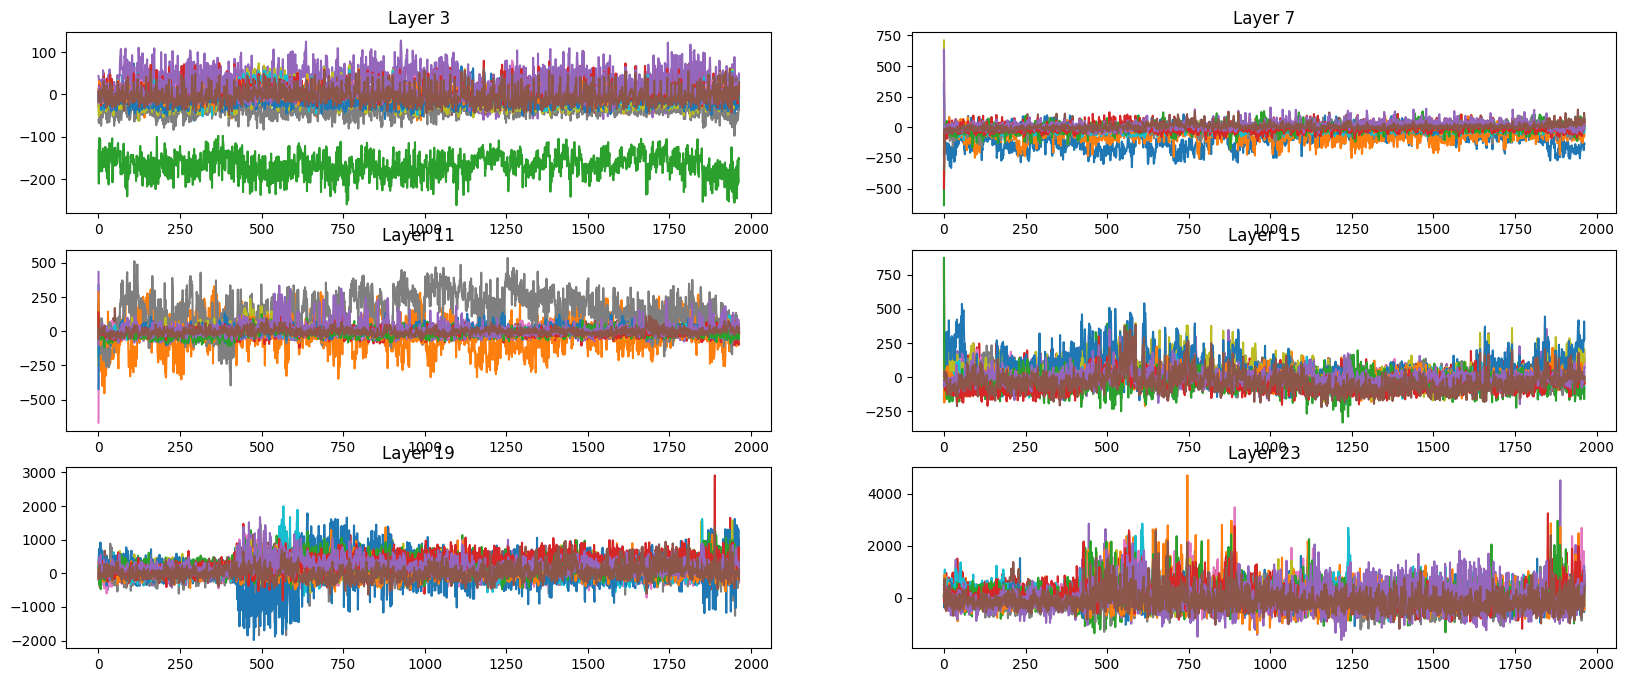

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(20, 8))
axes = axes.flatten()

for idx, layer in enumerate(results[0].keys()):
    axes[idx].plot(results[0][layer].T.cpu().to(torch.float32).numpy())
    axes[idx].set_title(f"Layer {layer}")
plt.show()

In [ ]:
layers = list(results[0].keys())
n_features = 16

for layer in layers:
    for feature in range(n_features):
        cheats = []
        noncheats = []
        for index, result in enumerate(results):
            if samples[index]['behavior_label'] == "cheat":
                cheats.append(result[layer][feature].mean().cpu().to(torch.float32).numpy())
            else:
                noncheats.append(result[layer][feature].mean().cpu().to(torch.float32).numpy())
        plt.title(f"Layer {layer}, Feature {feature}")
        plt.hist(cheats, label="cheat", alpha=0.5)
        plt.hist(noncheats, label="non-cheat", alpha=0.5)
        plt.legend()
        plt.show()

In [ ]:
layers = [3, 7, 11, 15, 19, 23]
n_features = 16

for layer in layers:
    for feature in range(n_features):
        cheats = []
        noncheats = []
        for index, result in enumerate(results):
            if samples[index]['behavior_label'] == "cheat":
                cheats.append(result[layer][feature].mean().cpu().to(torch.float32).numpy())
            else:
                noncheats.append(result[layer][feature].mean().cpu().to(torch.float32).numpy())
        plt.title(f"Layer {layer}, Feature {feature}")
        plt.hist(cheats, label="cheat", alpha=0.5)
        plt.hist(noncheats, label="non-cheat", alpha=0.5)
        plt.legend()
        plt.show()

In [95]:
interesting_features = {
    3: [78514, 42587, 5674, 84106],
    7: [82094, 43170, 87901],
    11: [100430, 84368, 15924, 114390, 73707, 128179, 57841, 64327],
    15: [50098, 1304, 32488, 53211, 122591, 97386, 49607],
    19: [64234],
    23: [100126, 107201, 66670, 39467, 60663, 75343]
}



In [143]:
cheats = []
noncheats = []
layer = 3
feature_idx = feature_dict[layer].index(42587)

for index, result in enumerate(results):
    if samples[index]['behavior_label'] == "cheat":
        cheats.append(results[index][layer][[feature_idx]].cpu().to(torch.float32).numpy().squeeze()[get_token_start_idx(formatted_prompts[index]):])
    else:
        noncheats.append(results[index][layer][[feature_idx]].cpu().to(torch.float32).numpy().squeeze()[get_token_start_idx(formatted_prompts[index]):])

In [146]:
min_len = min(min(len(arr) for arr in cheats), min(len(arr) for arr in noncheats))

# Resample each array to min_len
cheat_resampled = []
for arr in cheats:
    # Create interpolation function
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, min_len)
    f = interp1d(x_old, arr, kind='linear')
    cheat_resampled.append(f(x_new))

# Stack and compute mean
cheat_mean_result = np.mean(cheat_resampled, axis=0)

# Resample each array to min_len
noncheat_resampled = []
for arr in noncheats:
    # Create interpolation function
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, min_len)
    f = interp1d(x_old, arr, kind='linear')
    noncheat_resampled.append(f(x_new))

# Stack and compute mean
noncheat_mean_result = np.mean(noncheat_resampled, axis=0)

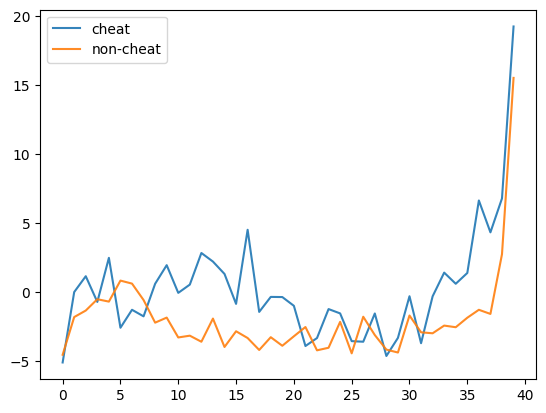

In [147]:
plt.plot(cheat_mean_result, alpha=0.9, label="cheat")
plt.plot(noncheat_mean_result, alpha=0.9, label="non-cheat")
plt.legend()
plt.plot()
plt.show()